# ENVIRONMENT SETUP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
import matplotlib.pyplot as plt
from __future__ import annotations
import matplotlib.ticker as ticker
from collections import defaultdict

env = gym.make("Blackjack-v1", sab=True)

# AGENT DEFINITION

In [ ]:
class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs])) #which is best, 0 or 1?

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [3]:
# hyperparameters
learning_rate = 0.001
n_episodes = 10_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [4]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 10000000/10000000 [27:52<00:00, 5979.06it/s]


# CONVERGENCE ANALYSIS

In [5]:
moving_avg = np.convolve(agent.training_error, np.ones(50000)/50000, mode='valid')

# Detect convergence parameters
window_size = 100          # Check stability over 100 windows (5M steps)
threshold_std = 0.0001      # Maximum allowed standard deviation
threshold_mean = 0.001      # Maximum absolute mean to consider "near convergence"
min_consecutive = 50       # Require 50 consecutive stable windows (~2.5M steps)

# Calculate rolling statistics
rolling_mean = pd.Series(moving_avg).rolling(window_size).mean().values
rolling_std = pd.Series(moving_avg).rolling(window_size).std().values

# Create mask for convergence criteria
mask = (
    (rolling_std < threshold_std) & 
    (np.abs(rolling_mean) < threshold_mean) &
    (~np.isnan(rolling_std))  # Ignore NaN values
)

# Find first sustained convergence period
convergence_start = None
current_streak = 0

for idx in range(len(mask)):
    if mask[idx]:
        current_streak += 1
        if current_streak >= min_consecutive:
            convergence_start = idx - min_consecutive + 1
            break
    else:
        current_streak = 0


    Convergence Detected!
    - Steps: 1.6M 
    - Episodes: 1.1M
    


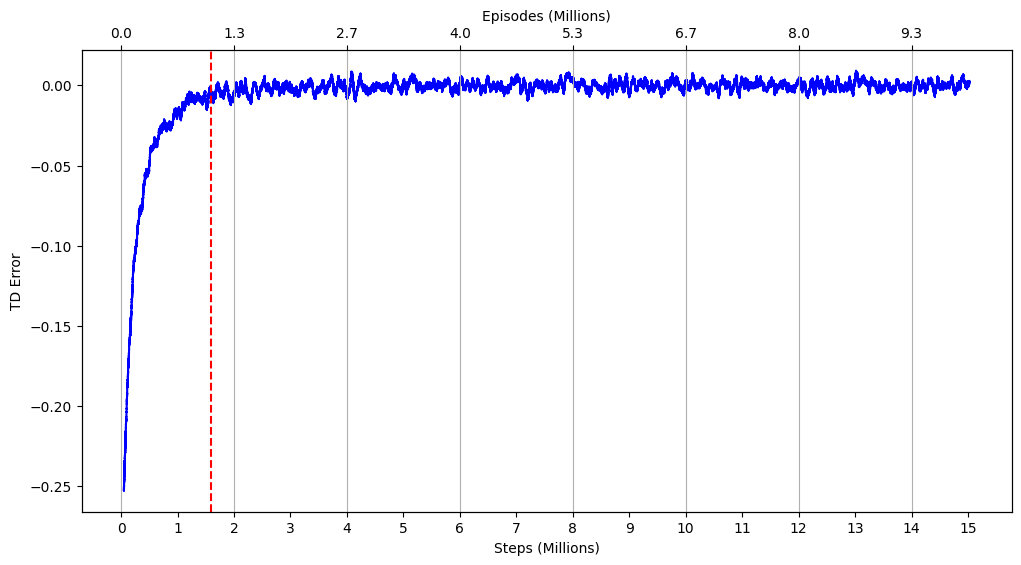

In [6]:
x_values = (np.arange(len(moving_avg)) + 50000) / 1e6  # Steps in millions

# Calculate average steps per episode
n_episodes = 10_000_000  # From your training setup
total_steps = len(agent.training_error)
avg_steps_per_episode = total_steps / n_episodes

# Create plot with dual x-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(x_values, moving_avg, label='TD Error (50k avg)', color='blue')

# Primary x-axis (steps)
ax1.set_xlabel('Steps (Millions)')
ax1.set_ylabel('TD Error')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Secondary x-axis (episodes)
ax2 = ax1.twiny()
ax2.set_xlabel('Episodes (Millions)')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, _: f'{x / avg_steps_per_episode:.1f}'))  # Convert steps to episodes
ax2.set_xlim(ax1.get_xlim())

# Add convergence line and print results
if convergence_start is not None:
    x_convergence_steps = x_values[convergence_start]
    x_convergence_episodes = x_convergence_steps / avg_steps_per_episode
    
    # Print both metrics
    print(f"""
    Convergence Detected!
    - Steps: {x_convergence_steps:.1f}M 
    - Episodes: {x_convergence_episodes:.1f}M
    """)
    
    # Add to plot
    ax1.axvline(x_convergence_steps, color='r', linestyle='--', 
                label=f'Convergence ({x_convergence_episodes:.1f}M Episodes)')

plt.grid(True)
plt.show()

In [7]:
reward_avg = np.convolve(env.return_queue, np.ones(50000)/50000, mode='valid')

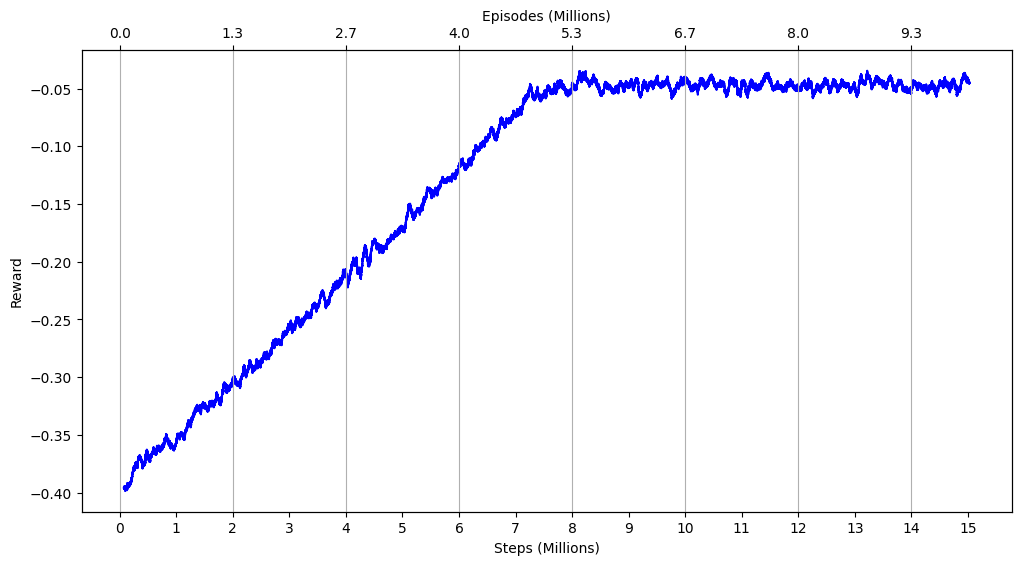

In [8]:
# Calculate total steps and episodes
total_steps = len(agent.training_error)  # From TD error data
n_episodes_total = len(env.return_queue)  # Total episodes
avg_steps_per_episode = total_steps / n_episodes_total

# X-values in steps (convert episode index to steps)
x_values_steps = ((np.arange(len(reward_avg)) + 50000) * avg_steps_per_episode) / 1e6  # Steps in millions

# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(x_values_steps, reward_avg, label='Reward (50k avg)', color='blue')

# Primary x-axis (steps at bottom)
ax1.set_xlabel('Steps (Millions)')
ax1.set_ylabel('Reward')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Steps in 1M increments

# Secondary x-axis (episodes at top)
ax2 = ax1.twiny()
ax2.set_xlabel('Episodes (Millions)')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, _: f'{x / avg_steps_per_episode:.1f}'))  # Convert steps to episodes
ax2.set_xlim(ax1.get_xlim())  # Match limits with primary axis

plt.grid(True)
plt.show()

### Controllo reward in fase finale

In [9]:
import itertools

n_ultima = 1

inizio = n_ultima*50000
fine = (n_ultima-1)*50000

sum(list(itertools.islice(env.return_queue, len(env.return_queue)-inizio, len(env.return_queue)-fine)))/50000

-0.04522

# WIN RATE ESTIMATION

In [ ]:
won = 0
n_eval_episodes = 960_400

for _ in range(n_eval_episodes):
    obs, info = env.reset()
    done = False
    while not done:
        action = np.argmax(agent.q_values[obs])  # Greedy policy
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    if reward == 1:
        won+=1

print(f"Win rate: {(won / n_eval_episodes)*100}%")

Win rate: 43.20577%


# OPTIMAL POLICY

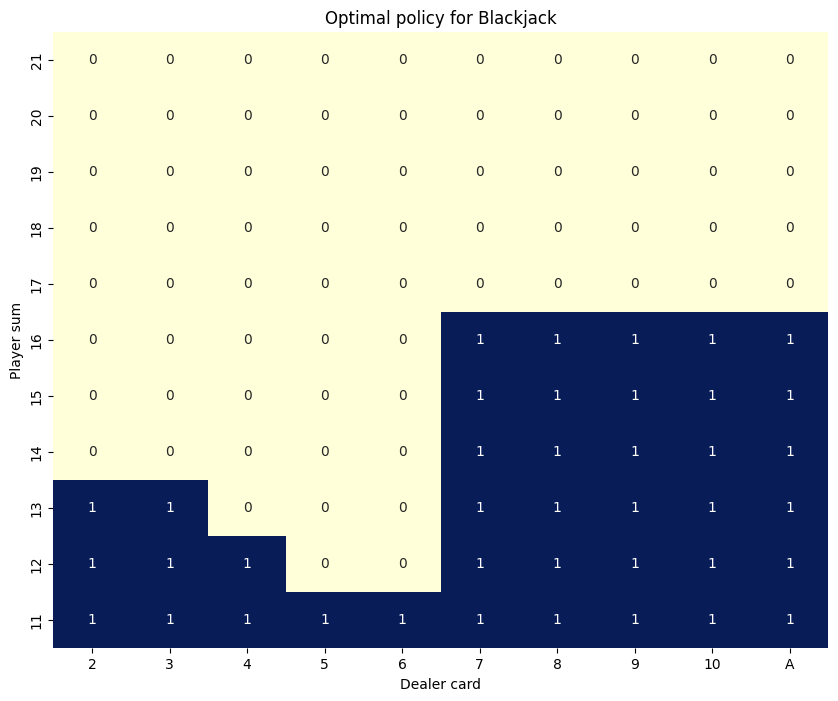

In [ ]:
import pandas as pd

#Create the policy matrix, for sums 12-21, dealer card 1-10, usable ace = No
policy = np.zeros((11, 10))
for player_sum in range(11, 22):
    for dealer_card in range(1, 11):
        policy[player_sum - 11, dealer_card - 1] = int(np.argmax(agent.q_values[(player_sum, dealer_card, False)]))
#Make it a df with the right index and columns
policy = pd.DataFrame(policy, index=range(11, 22), columns=range(1, 11))

#rename column 1 to 'A'
policy.rename(columns={1: 'A'}, inplace=True)

# Reordering columns (excluding 'A' and placing it at the end)
columns_order = [col for col in policy.columns if col != 'A'] + ['A']
rows_order = range(21,10, -1)
policy = policy.reindex(rows_order)
policy = policy[columns_order]


# Plot the policy
plt.figure(figsize=(10, 8))
sns.heatmap(policy, cmap="YlGnBu", annot=True, fmt="g", cbar=False)
plt.xlabel("Dealer card")
plt.ylabel("Player sum")
plt.title("Optimal policy for Blackjack")
plt.show()


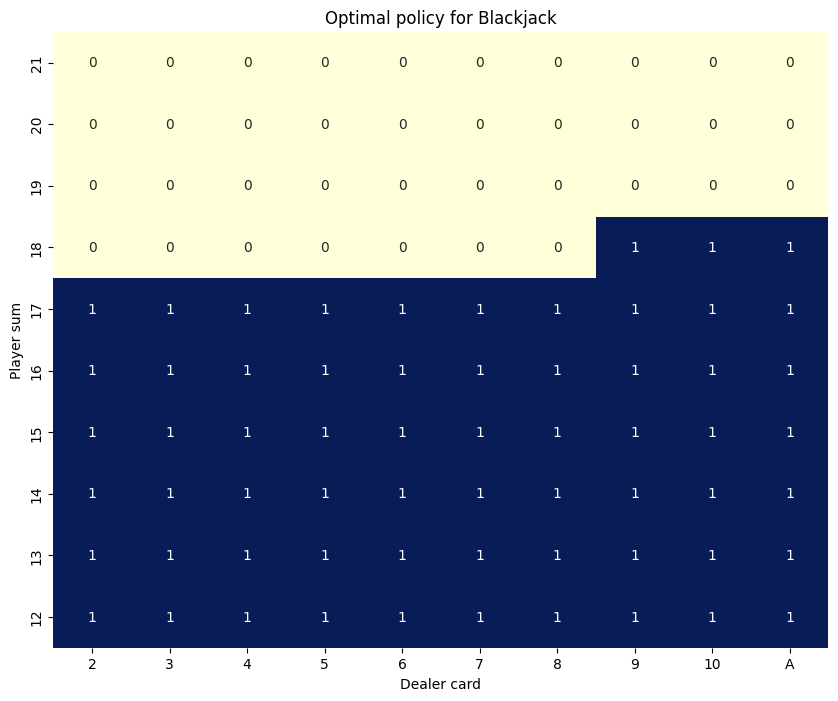

In [ ]:
import pandas as pd

#Create the policy matrix, for sums 12-21, dealer card 1-10, usable ace = No
policy = np.zeros((10, 10))
for player_sum in range(12, 22):
    for dealer_card in range(1, 11):
        policy[player_sum - 12, dealer_card - 1] = int(np.argmax(agent.q_values[(player_sum, dealer_card, True)]))
#Make it a df with the right index and columns
policy = pd.DataFrame(policy, index=range(12, 22), columns=range(1, 11))

#rename column 1 to 'A'
policy.rename(columns={1: 'A'}, inplace=True)

# Reordering columns (excluding 'A' and placing it at the end)
columns_order = [col for col in policy.columns if col != 'A'] + ['A']
rows_order = range(21,11, -1)
policy = policy.reindex(rows_order)
policy = policy[columns_order]


# Plot the policy
plt.figure(figsize=(10, 8))
sns.heatmap(policy, cmap="YlGnBu", annot=True, fmt="g", cbar=False)
plt.xlabel("Dealer card")
plt.ylabel("Player sum")
plt.title("Optimal policy for Blackjack")
plt.show()
